# Preparing the Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)
listingsNYC

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,21,3,2022-08-10,0.03,1,267,1,NaN
1,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.8038,-73.96751,Private room,75,2,118,2017-07-21,0.73,1,0,0,NaN
2,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,322,0,NaN
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,559,2022-11-20,3.38,1,79,50,NaN
4,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,175,30,49,2022-06-21,0.31,3,365,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,771962449581256963,Romántico y natural,421601513,Juan Carlos,Manhattan,Washington Heights,40.84727072881559,-73.94341916084775,Private room,80,5,0,NaN,NaN,3,358,0,NaN
41529,771967712456918474,Sunset Park Studio Sublet,326495,Laura Adriana,Brooklyn,Sunset Park,40.63832893587064,-74.01671019409663,Entire home/apt,42,30,0,NaN,NaN,3,89,0,NaN
41530,771971759808918693,9B5B Townhouse w/ Elevator & Private Entrance,316920152,Allison,Manhattan,Murray Hill,40.74690169639175,-73.97826030246593,Entire home/apt,3888,2,0,NaN,NaN,8,365,0,NaN
41531,771971822371481471,Huge 9B5B Townhouse w Elevator & Private Entr...,484979380,Natasha,Manhattan,Murray Hill,40.74959584319043,-73.98079769535242,Entire home/apt,3888,2,0,NaN,NaN,2,364,0,NaN


In [3]:
# Dropping all of the columns which we will not use
# listingsNYC= listingsNYC.drop(['last_review','license','latitude','longitude','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
# listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64'}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC['neighbourhood'].unique().shape[0]
listingsNYC

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,pps
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,21,3,2022-08-10,0.03,1,267,1,NaN,5775
1,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.8038,-73.96751,Private room,75,2,118,2017-07-21,0.73,1,0,0,NaN,150
2,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,322,0,NaN,1800
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,559,2022-11-20,3.38,1,79,50,NaN,136
4,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,175,30,49,2022-06-21,0.31,3,365,1,NaN,5250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41528,771962449581256963,Romántico y natural,421601513,Juan Carlos,Manhattan,Washington Heights,40.84727072881559,-73.94341916084775,Private room,80,5,0,NaN,NaN,3,358,0,NaN,400
41529,771967712456918474,Sunset Park Studio Sublet,326495,Laura Adriana,Brooklyn,Sunset Park,40.63832893587064,-74.01671019409663,Entire home/apt,42,30,0,NaN,NaN,3,89,0,NaN,1260
41530,771971759808918693,9B5B Townhouse w/ Elevator & Private Entrance,316920152,Allison,Manhattan,Murray Hill,40.74690169639175,-73.97826030246593,Entire home/apt,3888,2,0,NaN,NaN,8,365,0,NaN,7776
41531,771971822371481471,Huge 9B5B Townhouse w Elevator & Private Entr...,484979380,Natasha,Manhattan,Murray Hill,40.74959584319043,-73.98079769535242,Entire home/apt,3888,2,0,NaN,NaN,2,364,0,NaN,7776


<AxesSubplot:xlabel='room_type', ylabel='price'>

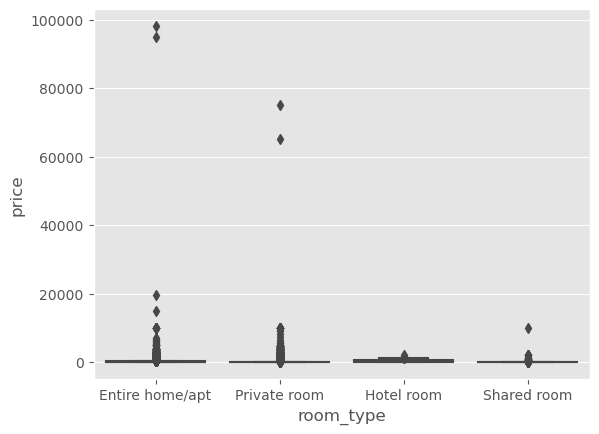

In [4]:
sns.boxplot(x = 'room_type', y = 'price', data = listingsNYC)